# Amazon Fine Food Reviews Analysis - Naive Bayes Application 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Featurization", "Hyper parameter(alpha)", "Train Error %", "Test Error %"]

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,precision_score,f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, recall_score, roc_auc_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [11]:
#Deduplication of entries
#final=sorted_data.drop_duplicates(subset={"Score"}, keep='first', inplace=False)
#final.shape

final_pos_reviews=final.loc[final['Score'] == 1]
final_neg_reviews=final.loc[final['Score']== 0]

In [12]:

final=final.sample(n=80000)
final=final.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

labels=final['Score']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [14]:
new_final=final.sort_values('Time')
final=new_final
new_labels=final['Score']

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
I'm getting crazy.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks


In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksumanth01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'how', 'm', 'an', 'he', 'was', 'few', 'being', 'this', "you'll", 'no', 'yourselves', 'against', 'hadn', 'down', 'does', 'am', 'that', 'aren', 'hasn', 'those', 'she', "you're", 'them', 'themselves', 'until', "couldn't", 'nor', 'wouldn', 'who', 'theirs', 'its', 'both', 'we', 'hers', 'if', 'were', 'why', 'ours', 'have', 'isn', "you'd", 'of', 'up', 'at', 'with', 'than', "mustn't", "hasn't", 'o', 'very', 'i', 'now', 'they', 're', 'll', 'in', 'which', 'out', 'other', 'yours', "needn't", 'above', 'yourself', 'haven', 'their', 'himself', 'off', 'such', 'are', 'shan', 'will', 't', 'it', 'mustn', 'wasn', 'ma', 'where', 'under', "doesn't", 've', 'while', "you've", 'but', 'into', 's', 'can', 'won', 'before', 'myself', 'our', 'my', 'a', 'has', "mightn't", "don't", 'and', 'from', 'because', 'you', 'by', 'some', 'doesn', "shan't", "wasn't", 'what', 'been', 'whom', "hadn't", 'needn', 'him', 'any', 'most', "isn't", 'shouldn', 'ain', 'not', 'on', 'couldn', 'again', "it's", 'is', 'more', 'y', 'had', "di

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [19]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# Bag of Words (BoW)

In [20]:
X = final['CleanedText']
y = new_labels
X_train = X[:int((70/100)*X.shape[0])]
y_train = y[:int((70/100)*y.shape[0])]

X_test = X[X_train.shape[0]:]
y_test = y[len(y_train):]

In [21]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts_train = count_vect.fit_transform(X_train)
train_voc = count_vect.vocabulary_
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (56000, 28684)
the number of unique words  28684


# **Applying Naive Bayes**

In [22]:
# 1. Applying Naive Bayes

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(final_counts_train, y_train)

count_vect1 = CountVectorizer(vocabulary = train_voc)
final_counts_test = count_vect1.fit_transform(X_test)

pred = clf.predict(final_counts_test) 

acc = accuracy_score(y_test, pred) * 100
precision = precision_score(y_test,pred) *100
recall = recall_score(y_test,pred) *100
f1 = f1_score(y_test,pred) * 100
confusion = confusion_matrix(y_test, pred)
TPR = confusion[1][1]/(confusion[1][0]+confusion[1][1])*100
FPR = confusion[0][1]/(confusion[0][0]+confusion[0][1])*100
TNR = confusion[0][0]/(confusion[0][0]+confusion[0][1])*100
FNR = confusion[1][0]/(confusion[1][0]+confusion[1][1])*100

roc = roc_auc_score(y_test, pred) *100

print('\nThe ROC-AUC score of the Multiclassifier Naive Bayes is %f%% ' % (roc))
print('\nThe accuracy of the Multiclassifier Naive Bayes is %f%% ' % (acc))
print('\nThe precision of the Multiclassifier Naive Bayes is %f%% ' % (precision))
print('\nThe recall of the Multiclassifier Naive Bayes is %f%% ' % (recall))
print('\nThe f1-score of the Multiclassifier Naive Bayes is %f%% ' % (f1))
print('\nThe TPR from the confusion matrix is %f%%' % (TPR ))
print('\nThe FPR from the confusion matrix is %f%%' % (FPR )) 
print('\nThe TNR from the confusion matrix is %f%%' % (TNR ))
print('\nThe FNR from the confusion matrix is %f%%' % (FNR ))



The ROC-AUC score of the Multiclassifier Naive Bayes is 50.257094% 

The accuracy of the Multiclassifier Naive Bayes is 81.062500% 

The precision of the Multiclassifier Naive Bayes is 82.625978% 

The recall of the Multiclassifier Naive Bayes is 97.577226% 

The f1-score of the Multiclassifier Naive Bayes is 89.481358% 

The TPR from the confusion matrix is 97.577226%

The FPR from the confusion matrix is 97.063037%

The TNR from the confusion matrix is 2.936963%

The FNR from the confusion matrix is 2.422774%


In [23]:
# 2. Applying 5-fold corss validation to find best alpha

X_tr = final_counts_train
y_tr = y_train


alpha_list =   [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10] 
cv_scores = []
for alp in tqdm(alpha_list):
  clf = MultinomialNB(alpha = alp)
  scores = cross_val_score(clf, X_tr, y_tr, cv=5, scoring='roc_auc')
  cv_scores.append(scores.mean())

best_alpha = alpha_list[cv_scores.index(max(cv_scores))]
train_error = round((100-max(cv_scores)*100),4)
print('\nThe best value of alpha is %d.' % best_alpha)

clf = MultinomialNB(alpha = best_alpha)
clf.fit(X_tr, y_tr)

pred = clf.predict(final_counts_test)

roc = roc_auc_score(y_test, pred) *100
confusion1 = confusion_matrix(y_test,pred)
test_error = round((100-roc),4)
print('\nThe ROC-AUC score of the Multiclassifier Naive Bayes with alpha=%d is %f%% ' % (best_alpha,roc))

x.add_row(["BoW - Naive Bayes ", best_alpha, train_error, test_error])

100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


The best value of alpha is 10.

The ROC-AUC score of the Multiclassifier Naive Bayes with alpha=10 is 50.063382% 



Confusion Matrix
[[    7  4181]
 [    8 19804]]
Confusion matrix heatmap


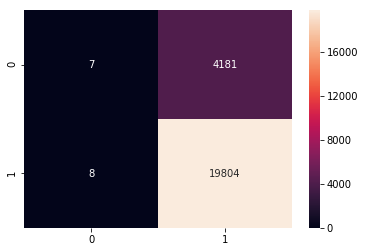

In [24]:
print('\nConfusion Matrix')
print(confusion1)
import seaborn as sns
print('Confusion matrix heatmap')
ax = sns.heatmap(confusion1, annot=True, fmt="d") 

In [25]:
# 3. Finding the top feprint(sorted0)print(sorted0)atures/words with high probability of occurance for both class of reviews(future selection)

words_list=count_vect1.get_feature_names()
d=clf.feature_log_prob_
top_neg_words = [words_list[i] for i in [list(d[0]).index(i) for i in (sorted(d[0],reverse=True))[:10]]]
top_pos_words = [words_list[i] for i in [list(d[1]).index(i) for i in (sorted(d[1],reverse=True))[:10]]]
print("Top 10 words/features with high probability in negative reviews:")

print("Top 10 words/features with high probability in negative reviews:")
print(top_neg_words)
print("\nTop 10 words/features with high probability in positive reviews:")
print(top_pos_words)

Top 10 words/features with high probability in negative reviews:
Top 10 words/features with high probability in negative reviews:
['like', 'tast', 'flavor', 'good', 'one', 'love', 'product', 'use', 'great', 'tri']

Top 10 words/features with high probability in positive reviews:
['like', 'tast', 'flavor', 'good', 'use', 'one', 'product', 'love', 'great', 'tri']


# TF-IDF

In [26]:
X = final['CleanedText']
y = new_labels
X_train = X[:int((70/100)*X.shape[0])]
y_train = y[:int((70/100)*y.shape[0])]

X_test = X[X_train.shape[0]:]
y_test = y[len(y_train):]

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(X_train)
train_voc = tf_idf_vect.vocabulary_
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (56000, 838029)
the number of unique words including both unigrams and bigrams  838029


In [28]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])

some sample features(unique words in the corpus) ['abc ive', 'abc kecap', 'abc news', 'abc six', 'abc sweet', 'abc veggi', 'abc wholesal', 'abd', 'abd alway', 'abd done']


In [29]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf_train[1,:].toarray()[0],features,25)

In [30]:
top_tfidf

,feature,tfidf
0,fli,0.335088
1,day practic,0.174656
2,fli drive,0.174656
3,fli hour,0.174656
4,one surfac,0.174656
5,hour trap,0.174656
6,avoid touch,0.174656
7,crazi consid,0.174656
8,infest fruit,0.174656
9,solut fli,0.174656


### **Applying Naive Bayes**

In [31]:
# 1. Applying Naive Bayes and calculation of metrics

from sklearn.naive_bayes import MultinomialNB

tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2),vocabulary = train_voc)
final_tf_idf_test = tf_idf_vect1.fit_transform(X_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

clf = MultinomialNB()
clf.fit(final_tf_idf_train, y_train)

pred = clf.predict(final_tf_idf_test)

acc = accuracy_score(y_test, pred) * 100
precision = precision_score(y_test,pred) *100
recall = recall_score(y_test,pred) *100
f1 = f1_score(y_test,pred) * 100
confusion = confusion_matrix(y_test, pred)
TPR = confusion[1][1]/(confusion[1][0]+confusion[1][1])*100
FPR = confusion[0][1]/(confusion[0][0]+confusion[0][1])*100
TNR = confusion[0][0]/(confusion[0][0]+confusion[0][1])*100
FNR = confusion[1][0]/(confusion[1][0]+confusion[1][1])*100

roc = roc_auc_score(y_test, pred) *100

print('\nThe ROC-AUC score of the Multiclassifier Naive Bayes is %f%% ' % (roc))
print('\nThe accuracy of the Multiclassifier Naive Bayes is %f%% ' % (acc))
print('\nThe precision of the Multiclassifier Naive Bayes is %f%% ' % (precision))
print('\nThe recall of the Multiclassifier Naive Bayes is %f%% ' % (recall))
print('\nThe f1-score of the Multiclassifier Naive Bayes is %f%% ' % (f1))
print('\nThe accuracy of the Multiclassifier Naive Bayes is %f%% ' % (acc))

print('\nThe TPR from the confusion matrix is %f%%' % (TPR ))
print('\nThe FPR from the confusion matrix is %f%%' % (FPR )) 
print('\nThe TNR from the confusion matrix is %f%%' % (TNR ))
print('\nThe FNR from the confusion matrix is %f%%' % (FNR ))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24000, 838029)
the number of unique words including both unigrams and bigrams  838029

The ROC-AUC score of the Multiclassifier Naive Bayes is 50.000000% 

The accuracy of the Multiclassifier Naive Bayes is 82.550000% 

The precision of the Multiclassifier Naive Bayes is 82.550000% 

The recall of the Multiclassifier Naive Bayes is 100.000000% 

The f1-score of the Multiclassifier Naive Bayes is 90.440975% 

The accuracy of the Multiclassifier Naive Bayes is 82.550000% 

The TPR from the confusion matrix is 100.000000%

The FPR from the confusion matrix is 100.000000%

The TNR from the confusion matrix is 0.000000%

The FNR from the confusion matrix is 0.000000%


In [32]:
# 2. Applying k-fold corss validation to find best alpha



alpha_list =   [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10] 
cv_scores = []
for alp in tqdm(alpha_list):
  clf = MultinomialNB(alpha = alp)
  scores = cross_val_score(clf, final_tf_idf_train, y_train, cv=5, scoring='roc_auc')
  cv_scores.append(scores.mean())

best_alpha = alpha_list[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %f.' % best_alpha)

train_error = round(100-max(cv_scores)*100,4)
clf = MultinomialNB(alpha = best_alpha)
clf.fit(final_tf_idf_train, y_train)

pred = clf.predict(final_tf_idf_test)

roc = roc_auc_score(y_test, pred) *100
confusion = confusion_matrix(y_test,pred)
test_error = round(100-roc,4)
print('\nThe ROC-AUC score of the Multiclassifier Naive Bayes is %f%% ' % (roc))
x.add_row(["TF-IDF - Naive Bayes ", best_alpha, train_error, test_error])


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]



The optimal value of alpha is 0.010000.

The ROC-AUC score of the Multiclassifier Naive Bayes is 50.025230% 



Confusion Matrix
[[   26  4162]
 [  113 19699]]
Confusion matrix heatmap


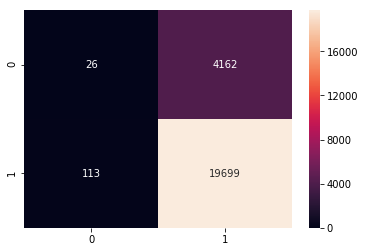

In [34]:
print('\nConfusion Matrix')
print(confusion)

import seaborn as sns
print('Confusion matrix heatmap')
ax = sns.heatmap(confusion, annot=True, fmt="d") 

In [35]:
# 3. Finding the top features/words with high probability of occurance for both class of reviews(future selection)

words_list=tf_idf_vect.get_feature_names()
d=clf.feature_log_prob_
top_neg_words = [words_list[i] for i in [list(d[0]).index(i) for i in (sorted(d[0],reverse=True))[:10]]]
top_pos_words = [words_list[i] for i in [list(d[1]).index(i) for i in (sorted(d[1],reverse=True))[:10]]]
print("Top 10 words/features with high probability in negative reviews:")
print(top_neg_words)
print("\nTop 10 words/features with high probability in positive reviews:")
print(top_pos_words)


Top 10 words/features with high probability in negative reviews:
['tast', 'like', 'love', 'good', 'great', 'coffe', 'tea', 'flavor', 'product', 'use']

Top 10 words/features with high probability in positive reviews:
['tast', 'like', 'tea', 'love', 'great', 'good', 'flavor', 'coffe', 'product', 'use']


# **OBSERVATION**

In [36]:
print(x)

+-----------------------+------------------------+---------------+--------------+
|     Featurization     | Hyper parameter(alpha) | Train Error % | Test Error % |
+-----------------------+------------------------+---------------+--------------+
|   BoW - Naive Bayes   |           10           |    49.9897    |   49.9366    |
| TF-IDF - Naive Bayes  |          0.01          |    49.4191    |   49.9748    |
+-----------------------+------------------------+---------------+--------------+


From the above table we can observe that in the given range of alpha values, Naive bayes for BoW performed best with alpha 10 and for TF-IDF alpha best value is 0.01. Both featurizations train error and test errors are almost similar. We have used used roc_auc score as metric as this dataset is quite imbalanced with more number of positive points. We have also listed top 10 words(most found) for both positive and negative class.
Alpha value is found out through 5 fold cross validation. Total number of datapoints used are 80k.